In [43]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import os
import matplotlib.pyplot as plt


In [44]:
gpu_train = torch.cuda.is_available()
print(f"GPU is activated: {gpu_train}")

GPU is activated: True


Preprocess Images

In [45]:
num_workers = 4
batch_size = 10
val_size = 0.20
path = 'food-101/images'

transform = transforms.Compose([
    transforms.Resize(200),
    transforms.RandomCrop(180),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

dataset = datasets.ImageFolder(root = path, transform = transform)

train_size = int(len(dataset) * 0.7)
test_size = int(len(dataset) * 0.15)
valid_size = len(dataset) - train_size - test_size
train_dataset, test_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, test_size, valid_size])

classes = []
for root, dirs, files in os.walk(f"./{path}"):
   classes.append(dirs)
classes = classes[0]

print(f"Train Size: {train_size} ({100 * train_size/len(dataset)}%)")
print(f"Test Size: {test_size} ({100 * test_size/len(dataset)}%)")
print(f"Validation Size: {valid_size} ({100 * valid_size/len(dataset)}%)")
print(f"Number of Classes: {len(classes)}")
print(f"Total Size: {len(dataset)}")

Train Size: 70700 (70.0%)
Test Size: 15150 (15.0%)
Validation Size: 15150 (15.0%)
Number of Classes: 101
Total Size: 101000


Create Trainloaders

In [46]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

Show Sample Images

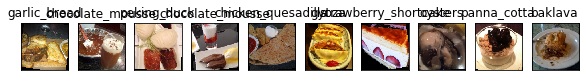

In [47]:
def imshow(img):
    img = img / 2 + .5
    plt.imshow(np.transpose(img, (1, 2, 0)))

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(10, 4))

# plot twenty images from the trainloader
for idx in np.arange(10):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])
    

In [48]:
import torch.nn as nn
import torch.nn.functional as F

In [60]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)

        
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(6400, 500)
        self.fc2 = nn.Linear(500, 101)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))

        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = Net()
print(model)

if gpu_train:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6400, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=101, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [61]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [62]:
# number of epochs
n_epochs = 30

valid_loss_min = np.Inf # sets the initial minimum validation loss

for epoch in range(1, n_epochs+1):

    # tracks training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    model.train()
    for data, target in train_loader:
        if gpu_train:
            data = data.cuda()
            target = target.cuda()
        # zeroes gradient
        optimizer.zero_grad()
        # applies the model to the data
        output = model(data)
        # calculates the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
  
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if gpu_train:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print(f'Epoch: {epoch} Training Loss: {train_loss} \tValidation Loss: {valid_loss}')
    
    # saves model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print(f'Validation loss decreased ({valid_loss_min} --> {valid_loss}).  Saving model ...')
        torch.save(model.state_dict(), 'fc101_model_midres.pt')
        valid_loss_min = valid_loss

Epoch: 1 Training Loss: 4.611470419750186 	Validation Loss: 4.5615091918718695
Validation loss decreased (inf --> 4.5615091918718695).  Saving model ...
Epoch: 2 Training Loss: 4.473425758879795 	Validation Loss: 4.375070325926979
Validation loss decreased (4.5615091918718695 --> 4.375070325926979).  Saving model ...
Epoch: 3 Training Loss: 4.2554198824195915 	Validation Loss: 4.110942334467822
Validation loss decreased (4.375070325926979 --> 4.110942334467822).  Saving model ...
Epoch: 4 Training Loss: 4.0097077665436895 	Validation Loss: 3.8055960489971805
Validation loss decreased (4.110942334467822 --> 3.8055960489971805).  Saving model ...
Epoch: 5 Training Loss: 3.780090444597193 	Validation Loss: 3.6017095729462776
Validation loss decreased (3.8055960489971805 --> 3.6017095729462776).  Saving model ...
Epoch: 6 Training Loss: 3.5930500957551064 	Validation Loss: 3.4654669648349876
Validation loss decreased (3.6017095729462776 --> 3.4654669648349876).  Saving model ...
Epoch: 7 T

In [63]:
# loads the model with the lowest validation loss
model.load_state_dict(torch.load('fc101_model_midres.pt'))

<All keys matched successfully>

In [65]:
# count test loss
test_loss = 0.0
class_correct = list(0. for i in range(101))
class_total = list(0. for i in range(101))

# enables evaluation mode
model.eval()
# iterate over test data to get test loss
for batch_idx, (data, target) in enumerate(test_loader):
    # move to GPU if CUDA is available
    if gpu_train:
        data, target = data.cuda(), target.cuda()
    # compute outputs from passing data into the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update the test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not gpu_train else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(10):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(101):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 2.430560

Test Accuracy of apple_pie:  6% ( 9/138)
Test Accuracy of baby_back_ribs: 46% (77/167)
Test Accuracy of baklava: 49% (72/146)
Test Accuracy of beef_carpaccio: 65% (100/153)
Test Accuracy of beef_tartare: 55% (87/158)
Test Accuracy of beet_salad: 40% (72/179)
Test Accuracy of beignets: 57% (83/144)
Test Accuracy of bibimbap: 72% (119/165)
Test Accuracy of bread_pudding: 25% (38/148)
Test Accuracy of breakfast_burrito: 14% (22/151)
Test Accuracy of bruschetta: 47% (75/157)
Test Accuracy of caesar_salad: 47% (71/150)
Test Accuracy of cannoli: 38% (57/149)
Test Accuracy of caprese_salad: 33% (52/154)
Test Accuracy of carrot_cake: 32% (50/154)
Test Accuracy of ceviche: 28% (44/153)
Test Accuracy of cheesecake: 32% (50/152)
Test Accuracy of cheese_plate: 30% (48/157)
Test Accuracy of chicken_curry: 33% (46/136)
Test Accuracy of chicken_quesadilla: 28% (42/147)
Test Accuracy of chicken_wings: 54% (83/151)
Test Accuracy of chocolate_cake: 55% (77/140)
Test Accuracy of choc

In [67]:
model.eval()
input_tensor = torch.rand(1,3,180,180).cuda()

script_model = torch.jit.trace(model,input_tensor)
script_model.save("fc101_ts_midres.pt")

In [68]:
print(classes)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou